When Bayesian A/B testing breaks down

Done correctly, Bayesian A/B testing can be useful, in particular the ability to safely "peek" at A/B tests.

But it can be quite destructive if - as often happens - it's done incorrectly.

The statement "95% probability that the treatment is better" looks nice, but how can be validate it?

The term is 'calibration'. If your prior isn't calibrated, the accurate number is 50% not 95%, no better than tossing a coin!

Before seeing how it can gone wrong, let's look at a successful case.

I simulated thousands of A/B tests, where the true effect for each was drawn from N(0,1).
Within each A/B test, the posterior was computed after after each user joined the A/B test.
The prior used to compute each prior was, as you might expect, N(0,1)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
seeds = [1234, 1337]

In [3]:
# To efficiently simulate experiments which might have millions - even billions - of
# users, I instead sample it at a large number of logarithmically-spaced sample sizes.
# The logic is that if you already have 1,000,000 users, the results are unlikely to
# change with the addition of one extra user. We can get the same results *as if* we
# recomputed a posterior after each extra user, but more efficiently.

def trace_of_sample_sizes(low, hig, num):
    raw = np.logspace(np.log10(low), np.log10(hig), num=num, base=10, dtype=int)
    uniq = np.unique(raw)
    return uniq

In [4]:
# The details don't matter, but each 'user' in each A/B test is normally distributed
# with variance defined here. The mean is the true parameter which we are trying
# to estimate.
VARIANCE_OF_ONE_OBSERVATION = 1 # An arbitrary choice, and I don't think it affects the overall findings in any way

def simulate_many_experiments(M, low, hig, num, true_dist):
    # Simulate M A/B tests, where the sample size starts at 'low'
    # and ends at 'hig'. 'num' is the number of logarithmically-spaced
    # times at which the posterior will be computed (see later cells)
    # 'true_dist' is the distribution from which the true parameter
    # is drawn - one draw for each of the M A/B tests.
    sizes = trace_of_sample_sizes(low, hig, num)
    _n_new = np.concatenate(([sizes[0]], sizes[1:] - sizes[:-1]))
    true_effects = true_dist.rvs(M, random_state = seeds[0])
    df = pd.DataFrame(dict(
        exp_id = [ m for m in range(M) for _ in range(len(sizes))],
        theta = [ effect for effect in true_effects for _ in range(len(sizes))],
        n = M * sizes.tolist(),
        _n_new = M * _n_new.tolist(),
    ))
    df['_x_extra'] = norm(
        loc=df['theta'] * df['_n_new'],
        scale = np.sqrt(df['_n_new'] * VARIANCE_OF_ONE_OBSERVATION),
    ).rvs(random_state = seeds[1])
    df['_x_total'] = df.groupby('exp_id', sort=False)._x_extra.cumsum()
    df['theta_hat'] = df['_x_total'] / df['n']
    return df

#df = simulate_many_experiments(5, 1e1, 1e5, 3, norm(scale=0.1))

# This next cell is purely a sanity check that the numbers are correctly computed

This means confirming that $\hat\theta$ has the expected mean (i.e. it's unbiased) and variance.

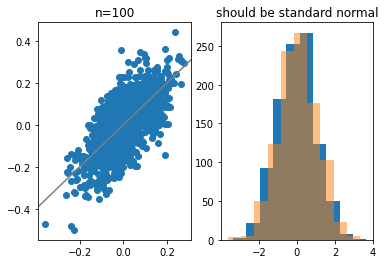

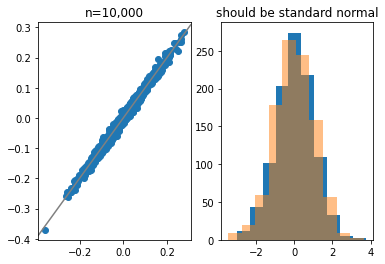

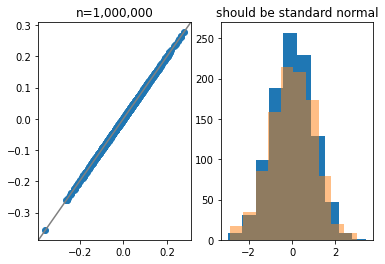

In [5]:
df = simulate_many_experiments(1000, 1e2, 1e6, 3, norm(scale=0.1))
for n, just_one_n in df.groupby('n'):
    plt.subplot(1,2,1)
    
    plt.scatter(just_one_n['theta'], just_one_n['theta_hat'])
    plt.axline((0,0), slope=1, color='grey')
    plt.title(f"n={n:,}")
    
    plt.subplot(1,2,2)
    should_be_uniform_01 = (
        (just_one_n['theta_hat'] - just_one_n['theta'])
        *
        np.sqrt(n)
        /
        np.sqrt(VARIANCE_OF_ONE_OBSERVATION)
    )
    plt.hist(should_be_uniform_01)
    plt.title("should be standard normal")
    plt.hist(norm().rvs(len(just_one_n)), alpha=0.5)
    
    plt.show()

# This next cell uses 'simulate_many_experiments' to simulate many experiments and compute the posterior too

The prior is normally distributed with center at zero, with the variance specified as the first
parameter to `compute_posteriors`.


In [6]:
def compute_posteriors(prior_variance, *l, **kw):
    df = simulate_many_experiments(*l, **kw)
    prior_precision = 1 / prior_variance
    likelihood_precision = df['n'] / VARIANCE_OF_ONE_OBSERVATION
    posterior_precision = prior_precision + likelihood_precision
    df.insert(0, 'posterior_precision', posterior_precision)
    # The posterior mean is a weighted average of the two means, weighted
    # by the precision
    prior_mean = 0
    likelihood_mean = df['theta_hat']
    posterior_mean = (
        (
            prior_mean * prior_precision
          + likelihood_mean * likelihood_precision
        )
        /
        (
                         prior_precision
          +                   likelihood_precision
        )
    )
    df.insert(0, 'posterior_mean', posterior_mean)
    df.insert(
        0,
        'posterior_cdf',
        norm(scale = 1/np.sqrt(df['posterior_precision'])).cdf(df['posterior_mean']),
    )
    return df

# Calibration curves

Regardless of how or why the A/B test is stopped, each simulation ends with two numbers: the final posterior probability that $\theta$ is positive, and the binary flag of whether the true $\theta$ is positive.

Of all the simulations that end with the posterior probability between 89% and 91%, we would expect the true theta to be positive in about 90% of those simulations.

To check this _calibration_, we sort the experiments by the probability and then plot two curves: the cumulative sum of the posterior probabilities, and the cumulative number of times the true $\theta$ was positive. They should coincide.

well behaved at large sample sizes


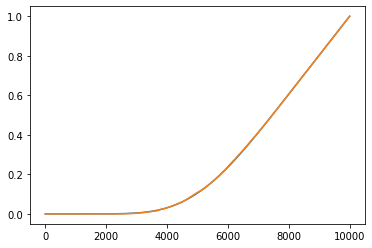

In [7]:
print('well behaved at large sample sizes')
_ = compute_posteriors(.00001, 10000, 1e1, 1e6, 6, norm(scale=np.sqrt(.00001))).query('n==1e6').eval('true_dir = theta > 0')[['true_dir', 'posterior_cdf']].sort_values('posterior_cdf').reset_index(drop=True)
plt.plot(_.posterior_cdf.cumsum() / _.posterior_cdf.sum())
plt.plot(_.true_dir.cumsum() / _.true_dir.sum())
plt.show()

# early stopping

But now we see when it breaks down. The calibration works if - and only if - the true prior
is the same as the prior that's used while computing the posteriors. When they differ, problems
arise; in particular, if the prior used in the computations is broader than it should be.

In these final simulations I use 'early stopping', where the simulation stops when the "probabality that treatment is better" goes above 90% or below 10%. I don't think this makes the calibration problem worse exactly, but it makes the simulations more relevant to the real world and also makes it easy to understand the results.

If you do 1,000 simulations and 50% end with ">90% probability that treatment is better" and 50% end with "<10% probability that treatment is better", then we expect that about 90% of the experiments to end with the right result.

However, if the prior is about 10 times broader than it should be, then the correctness is only about 65% on average.

Finally, if the ratio is 100:1, then the correctness is only about 53%, barely better than tossing a coin! 

Out of 10000 runs, 9995 have finished
90773265


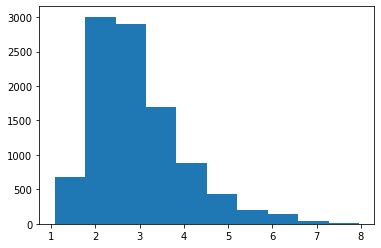

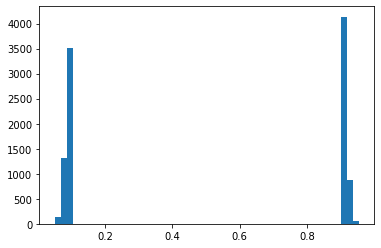

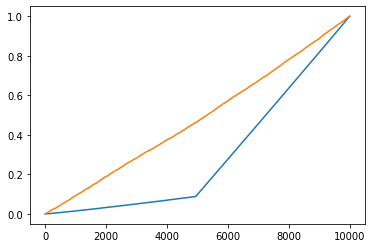

,posterior_cdf,true_dir
hat_dir,,
False,0.089793,0.474590
True,0.910353,0.540348


CPU times: user 16.7 s, sys: 1.73 s, total: 18.5 s
Wall time: 18 s


In [8]:
%%time
true_std, used_std = 0.001, 0.100
M = 10000
_ = (
    compute_posteriors(used_std ** 2,
                       M, 1e1, 1e8, 1000,
                       norm(scale=true_std),
                      )
    .eval('true_dir = theta > 0')
    .query('posterior_cdf < 0.10 or posterior_cdf > 0.90')
    # The the first result from each experiment, immediately after the
    # probability is less than 10% or more than 90%
    .groupby('exp_id', sort=False).take([0])
    .sort_values('posterior_cdf')
)
print(f"Out of {M} runs, {len(_)} have finished")
_ = (
    _
    [['posterior_cdf', 'true_dir', 'n']]
    .reset_index(drop=True)
)
print(_.n.max())

plt.hist(np.log10(_.n));
plt.show()

plt.hist(_.posterior_cdf, bins=50);
plt.show()

plt.plot(_.posterior_cdf.cumsum() / _.posterior_cdf.sum())
plt.plot(_.true_dir.cumsum() / _.true_dir.sum())
plt.show()

display(
    _
    .eval('hat_dir = posterior_cdf > 0.50')
    .groupby('hat_dir')[['posterior_cdf', 'true_dir']].mean()
)

A ratio of 100:1 is not extreme. In fact, it's quite relevant to the A/B tests at my workplace.
I know from a meta-analysis of hundreds of our A/B tests that the true effect is only rarely greater than 1%. The prior that is used by one of the third party A/B systems (Eppo) has a prior whose standard deviation is about 100 times. Therefore, companies that are considering A/B testing should take charge of setting their prior at a suitably conservative level that is appropriate for the true effects they see. It's dangerous to allow unrestricted prior choice

Out of 10000 runs, 9992 have finished
90773265


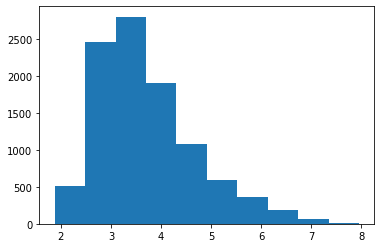

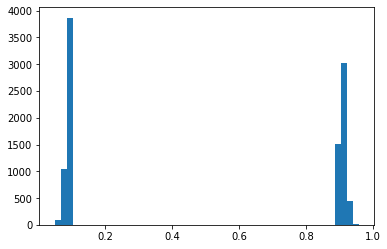

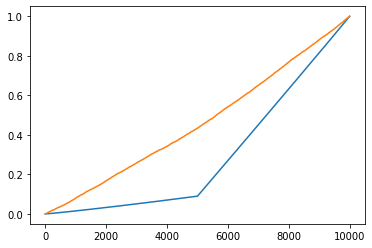

,posterior_cdf,true_dir
hat_dir,,
False,0.089800,0.440664
True,0.910156,0.574975


CPU times: user 18.1 s, sys: 1.63 s, total: 19.8 s
Wall time: 19.3 s


In [9]:
%%time
true_std, used_std = 0.001, 0.040
M = 10000
_ = (
    compute_posteriors(used_std ** 2,
                       M, 1e1, 1e8, 1000,
                       norm(scale=true_std),
                      )
    .eval('true_dir = theta > 0')
    .query('posterior_cdf < 0.10 or posterior_cdf > 0.90')
    # The the first result from each experiment, immediately after the
    # probability is less than 10% or more than 90%
    .groupby('exp_id', sort=False).take([0])
    .sort_values('posterior_cdf')
)
print(f"Out of {M} runs, {len(_)} have finished")
_ = (
    _
    [['posterior_cdf', 'true_dir', 'n']]
    .reset_index(drop=True)
)
print(_.n.max())

plt.hist(np.log10(_.n));
plt.show()

plt.hist(_.posterior_cdf, bins=50);
plt.show()

plt.plot(_.posterior_cdf.cumsum() / _.posterior_cdf.sum())
plt.plot(_.true_dir.cumsum() / _.true_dir.sum())
plt.show()

display(
    _
    .eval('hat_dir = posterior_cdf > 0.50')
    .groupby('hat_dir')[['posterior_cdf', 'true_dir']].mean()
)